# Ch 4. 醫療物資疫苗配送路線最佳化

本作業以「醫療物資與疫苗配送」為應用情境，讓同學透過多種演算法解決 旅行推銷員問題（TSP, Traveling Salesman Problem），體驗如何將理論演算法應用於實際醫療物流的最佳化問題。完成本作業後，你將能夠：

1. 實作並比較四種最佳化方法（窮舉法、動態規劃法、最近鄰居法、基因演算法）
2. 以圖表與數據分析不同演算法的特性與效率差異
3. 反思演算法於真實醫療配送場景中的應用與限制

## Section 0. 預備知識與資料準備

拿到資料第一件事情，就是要載入資料

In [1]:
import pandas as pd
df_hospital = pd.read_csv("hospitals.csv")
df_hospital.head()

,x,y
0,0.0,9.3
1,34.8,67.3
2,53.2,100.0
3,42.2,59.6
4,30.7,37.9


這很明顯就是地圖座標，但是看表格實在不好操作，所以就把這些點印在 scatter plot 上面

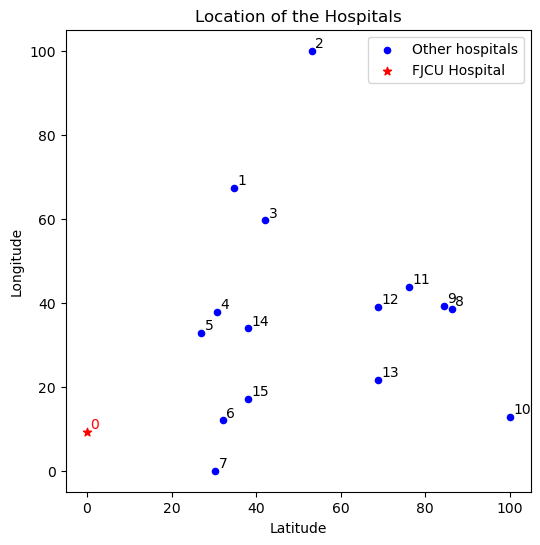

In [2]:
import matplotlib.pyplot as plt

x, y = df_hospital.iloc[1:][["x"]], df_hospital.iloc[1:][["y"]]
x_0, y_0 = df_hospital.loc[0, "x"], df_hospital.loc[0, "y"]

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title("Location of the Hospitals")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.scatter(x, y, s=20, color="blue", label="Other hospitals")
ax.scatter(
    x_0,
    y_0,
    color="red",
    marker="*",
    zorder=5,
    label="FJCU Hospital",
)

for index, row in df_hospital.iterrows():
    text_color = "red" if index == 0 else "black"
    ax.text(
        row["x"] + 0.8,
        row["y"] + 0.8,
        str(index),
        fontsize=10,
        ha="left",
        color=text_color,
    )

ax.legend()
plt.show()

現在陽春地圖已經有了，所以可以進入四種演算法的實作

## Section 1. Exhaustive Search

> _嘗試以窮舉方式找出最短路徑。若計算量過大、無法在合理時間內完成，請估算理論上所需的計算次數與時間，並討論其可行性_

### Step A. Time Complexity

窮舉法（Exhaustive Search）可以說是最暴力破解的方法之一，對於「從原點出發找另外 15 個點路徑數量」題目，是經典的排列組合問題，理論上會存在 $15! = 1,307,674,368,000$ 個路徑。現在問題在於要如何透過 loop 來迭代出這 $15!$ 個路徑、並且在每一條路徑中加入起點來計算總距離？

但換個角度想，問題並不在於「要如何迭代」，而是因為計算效率的問題。針對這類 TSP 的窮舉解法的時間複雜度為 $O((N-1)!)$ 或 $O(N!)$，屬於階乘時間（Factorial Time），在時間效率上可以說是難以實現。思考一次 Euclidean 距離 $d = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$ 就包含兩次減法、兩次乘法、一次加法、還有一次平方根運算。這之外，還需要執行 $15!$ 次的距離計算，這運算量可想而知非常大。以下是透過 NumPy 進行矩陣運算的程式碼：

In [3]:
# import itertools
# import time
# import numpy as np
# from scipy.spatial.distance import cdist

# # 1. Permutation
# A = df_hospital[["x", "y"]].values
# D = cdist(A, A, metric="euclidean")
# H = list(range(1, 16))
# P_gen = itertools.permutations(H)
# d_min = float("inf")
# p_min = []
# c = 0

# # 2. Exhaustive Search
# t_start = time.perf_counter()

# for p in P_gen:
#     # NumPy array for indexing
#     p_curr = np.array([0] + list(p) + [0])
#     idx_a = p_curr[:-1]  # from
#     idx_b = p_curr[1:]  # to
#     d_curr = D[idx_a, idx_b].sum()

#     # find best dist
#     if d_curr < d_min:
#         d_min = d_curr
#         p_min = list(p_curr)
#     c += 1

#     # Print progress update per 1 billion paths
#     if c % 1_000_000_000 == 0:
#         t_elapsed = time.perf_counter() - t_start
#         print(f"Checked {c // 1_000_000_000} billion paths... (Time: {t_elapsed:.2f}s)")

在 Apple Mac Mini M4 晶片下進行操作，實際執行得出

```text
Checked 1 billion paths... (Time: 1852.93s)
Checked 2 billion paths... (Time: 3691.76s)
Checked 3 billion paths... (Time: 5538.67s)
Checked 4 billion paths... (Time: 7397.20s)
Checked 5 billion paths... (Time: 9265.18s)
Checked 6 billion paths... (Time: 11123.56s)
Checked 7 billion paths... (Time: 13012.56s)
Checked 8 billion paths... (Time: 14901.73s)
Checked 9 billion paths... (Time: 16784.20s)
```

實際執行 90 億次路徑的總消耗時間為 $16784.20$ 秒。可以計算出平均每 10 億路徑的消耗時間 $t_{b,\text{avg}}$

$$
t_{b,\text{avg}} = \frac{16784.20 \text{ sec}}{9 \text{ intervals}} \approx 1864.91 \text{ sec/interval}
$$

使用這個平均速率 $R_{\text{avg}}$ 來推估總執行時間 $T$：

$$
R_{\text{avg}} = \frac{1,000,000,000 \text{ paths}}{1864.91 \text{ s}} \approx 536,218 \text{ paths/second}
$$

總執行時間 $T$ 為：

$$
\begin{aligned}
T &= \left(\frac{N}{b}\right) \times t_{b,\text{avg}} \\
&= \left(\frac{1,307,674,368,000}{1,000,000,000}\right) \times 1864.91 \text{ sec} \\
&\approx 1307.674 \times 1864.91 \text{ sec} \\
&\approx 2,438,820 \text{ sec}
\end{aligned}
$$

時間換算下來大約是 28.23 天左右，在實務上根本不可行。那會導致這情況的根本原因，在於 TSP 問題本身就是 NP-Complete 的問題。在 _Step B_ 中會使用數學的形式說明為何 TSP 是 NP-Complete，因此窮舉法難以進行

### Step B. TSP is NP Complete

有關圖論相關基礎知識，可以參考這篇在 Medium 論壇上的文章 [離散數學學習筆記：圖論（Graph Theory）](https://medium.com/@ralph-tech/離散數學學習筆記-圖論-graph-theory-f2241cc1134a)。那來回頭思考原問題：

> 從原點出發找另外 15 個點路徑數量以找出最短路徑

這份作業的第一部分本身就是一個 Traveling Salesman 問題（以下簡稱 TSP），而其基底結構是 Hamilton Circuit，用來判斷一個圖 $G$ 是否存在一條 **每個節點只走過一次** 的回路：

> 給定加權圖 $G$ 中，是否存在一條總權重小於或等於 $k$ 的 Hamilton Circuit？

現在這些數學定義可以描述出 TSP 問題的圖論結構，以及該問題的形式化定義。那 Karp (1972) 有明確將 Hamilton Circuit 列為 NP-Complete 的問題之一 [1]；而 Garey & Johnson (1979) 在 _Section 2.3 Nondeterministic Computation and the Class NP_ 中直接證明 TSP 屬於 NP-hard。換句話說，就是在多項式時間內如 $O(N^2)$ 或 $O(N^3)$ 等，無法解決所有 TSP 實例的演算法，因此證明 $O(N!)$ 窮舉法本身就相當沒有效率 [2]

有關資料結構（或離散數學）中的圖論如何對應到這個 TSP 問題，可參考以下說明

#### 1. Formal Definitions

##### Definition 0. NP-Hard and NP-Complete

計算複雜度類別 $\text{NP}$ 與 $\text{NP-Complete}$ 的形式化定義，來自於 **Cook (1971) [1]** 及其與 **Levin (1973) [2]** 的獨立發現。令 $L, L_C$ 為語言（Languages），則

1. $L$ 被定義為 NP-Hard，若且唯若所有 $\text{NP}$ 中的語言 $L'$ 都能在多項式時間內歸約至 $L$：

    $$
    L \in \text{NP-Hard} \iff (\forall L' \in \text{NP}, L' \le_P L)
    $$

2. 一個基於歸約傳遞性的等價定義是：$L$ 為 NP-Hard，若且唯若 **存在** 一個 NP-Complete 語言 $L_C$ 使得 $L_C \le_P L$，寫為

    $$
    L \in \text{NP-Hard} \iff (\exists L_C \in \text{NP-Complete} \text{ s.t. } L_C \le_P L)
    $$

3. $L$ 被定義為 NP-Complete，若且唯若 (i) $L \in \text{NP}$ 且 (ii) $L$ 是 NP-Hard。

    $$
    L \in \text{NP-Complete} \iff (L \in \text{NP}) \land (L \in \text{NP-Hard})
    $$

##### Definition 1. Graph

一個圖（Graph） $G$ 是一個序列組合 $(V, E)$，其中 $V$ 是一個有限的節點集合、而 $E \subseteq \{\{u, v\} \mid u, v \in V, u \neq v\}$ 是一個邊（edge）的集合

##### Definition 2. Undirected Hamiltonian Circuit (UHC)

令 $G = (V, E)$ 為一個 $n$ 節點的圖。一個 UHC 是 $V$ 的一個排列 $\pi = \langle v_1, v_2, \dots, v_n \rangle$，滿足邊的條件如下：

$$
\{v_n, v_1\} \in E \quad \land \quad \forall i \in \{1, \dots, n-1\}, \{v_i, v_{i+1}\} \in E
$$

此處 $\pi$ 是 $V$ 的一個排列，已隱含 $\pi$ 是一個包含 $V$ 中所有節點、長度為 $n$、且所有元素互不相同的序列

##### Definition 3. STSP Instance: Weighted Complete Graph

一個 $n$ 節點的 TSP 實例是一個序列組合 $(V, w)$，其中：
1. $V$ 是一個包含 $n$ 個節點的有限集合
2. $w: E_K \to \mathbf{R}^+$ 是一個權重函數，其定義域 $E_K$ 是基於 $V$ 的完全圖 $K_n$ 的邊集合

##### Definition 4. STSP Optimization

令 $(V, w)$ 為一個如 Definition 3 所述的 STSP 問題；令 $\Pi_V$ 為 $V$ 上所有 UHC 的集合。而 STSP 最佳化問題的是找到一個排列 $\pi^* \in \Pi_V$ 使得其總路徑權重 $W(\pi^\ast)$ 有最小值：

$$
\begin{aligned}
W(\pi) &:= \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\}) \\
\pi^* &:= \arg\min_{\pi \in \Pi_V} W(\pi)
\end{aligned}
$$

由於路徑 $\langle v_1, \dots, v_n \rangle$ 與 $\langle v_n, \dots, v_1 \rangle$ 總距離相同，STSP 的搜尋空間 $\Pi_V$ 實際上是 $(N-1)!/2$。但對於 $O(N!)$ 窮舉法分析，使用 $(N-1)!$ 或 $N!$ 在複雜度級別上是相同的。這個過程就是透過數學方法，將這次題目中的 TSP 用形式化的方式寫成 UHC

##### Definition 5. The Traveling-Salesperson Decision Problem `TSP-DECISION`

`TSP-DECISION` 在數學上寫成 $L_{\text{TSP}}$ ，是所有 STSP 問題 $(V, w)$ 與邊界 $k$ 的編碼 $\langle (V, w), k \rangle$ 的集合，其中 $k \in \mathbf{R}$，且存在一個 UHC $\pi \in \Pi_V$ 滿足 $W(\pi) \le k$。寫為：

$$L_{\text{TSP}} := \{ \langle (V, w), k \rangle \mid \exists \pi \in \Pi_V \text{ s.t. } W(\pi) \le k \}$$

#### 2. Inducing TSP-DECISION is NP-Complete

Cormen et al. (2022) 在 _Section 34.5.4 "The traveling-salesperson problem"_ 中，在技術上是證明 **無向** 對稱 TSP 的 NP-hard 的問題 [5]

##### Lemma 1. Membership of TSP-DECISION in NP

令 $L_{\text{TSP}}$ 為 _Definition 5_ 中定義的 TSP-DECISION 語言，則 $L_{\text{TSP}} \in \text{NP}$

**【Proof】**

若要證明 $L_{\text{TSP}} \in \text{NP}$，則需要建立一個多項式時間的驗證機制 $V$，其中

- 一個 STSP 實例 $\langle (V, w), k \rangle$ 及一個 certificate $\pi$
- $V$ 中 $n$ 個節點的排列 $\pi = \langle v_1, v_2, \dots, v_n \rangle$

而$V$ 需要操作以下演算法：

1. 驗證 $\pi$ 是 $V$ 的有效排列 (Time: $O(n \log n)$ or $O(n)$)
2. 計算總權重 $W(\pi) := \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\})$ (Time: $O(n)$)
3. 檢查 $W(\pi) \le k$ (Time: $O(1)$)

$V$ 的總執行時間為 polynomial time（以 $n = |V|$ 為界）。若 1 到 3 均成立，則驗證機制接受該輸入。這時因為存在一個多項式時間的驗證機制，故 $L_{\text{TSP}} \in \text{NP}$ 成立 $\blacksquare$

##### Lemma 2. NP-Hardness of TSP-DECISION

令 $L_{\text{TSP}}$ 為 Definition 5 中定義的 TSP-DECISION 語言

**【Proof】**

若要證明 $L_{\text{TSP}}$ 為 NP-Hard，則需要寫出已知的 NP-Complete 語言 $L_{\text{HAM}}$ 可在多項式時間內歸約至 $L_{\text{TSP}}$

- 使用已知的 NP-Complete 語言 $L_{\text{HAM}}$ (Karp, 1972)，定義為

    $$
    L_{\text{HAM}} := \{ \langle G \rangle \mid G=(V, E) \text{ is an undirected graph containing a Hamiltonian circuit} \}
    $$

- 建立一個多項式時間函數 $f$，將 $L_{\text{HAM}}$ 問題 $\langle G \rangle$ 映射到 $L_{\text{TSP}}$ 問題 $\langle (V, w), k \rangle$。則 $f$ 的構造演算法可以令 $\langle G=(V, E) \rangle$ 為輸入、$\langle (V', w), k \rangle$ 為輸出；令 $V' = V$ 且 $k = 0$。則 $\forall \{u, v\} \subseteq V$，定義權重函數 $w$：$$w(\{u, v\}) = \begin{cases} 0 & \text{if } \{u, v\} \in E \\ 1 & \text{if } \{u, v\} \notin E \end{cases}$$

此歸約 $f$ 的執行時間為 $O(|V|^2)$（用於建立 $w$），為多項式時間。必須證明 $\langle G \rangle \in L_{\text{HAM}} \iff f(\langle G \rangle) \in L_{\text{TSP}}$

1.  **Forward Implication ($\implies$)**

    **假設 $\langle G \rangle \in L_{\text{HAM}}$**

    $$ 
    \begin{aligned}
        & \langle G \rangle \in L_{\text{HAM}} \\
        \implies \quad & (\exists \text{ UHC } \pi = \langle v_1, \dots, v_n \rangle \text{ in } G) & & \text{; Definition of } L_{\text{HAM}} \\
        \implies \quad & (\forall i \in [1, n-1], \{v_i, v_{i+1}\} \in E) \land (\{v_n, v_1\} \in E) & & \text{; Definition 2 (UHC)} \\
        \implies \quad & (\forall i \in [1, n-1], w(\{v_i, v_{i+1}\}) = 0) \land (w(\{v_n, v_1\}) = 0) & & \text{; Definition of } w \text{ in reduction } f \\
        \implies \quad & W(\pi) = \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\}) = 0 & & \text{; Definition 4 (STSP)} \\
        \implies \quad & W(\pi) \le 0 & & \text{; Since } k=0 \text{ in reduction } f \\
        \implies \quad & \langle (V, w), 0 \rangle \in L_{\text{TSP}} & & \text{; Definition 5 (TSP-DECISION)}
    \end{aligned}
    $$

2.  **Backward Implication ($\impliedby$)**

    假設 $\langle (V, w), 0 \rangle = f(\langle G \rangle) \in L_{\text{TSP}}$

    $$  
    \begin{aligned}
        & \langle (V, w), 0 \rangle \in L_{\text{TSP}} \\
        \implies \quad & (\exists \text{ UHC } \pi = \langle v_1, \dots, v_n \rangle \text{ s.t. } W(\pi) \le 0) & & \text{; Definition 5 (TSP-DECISION), with } k=0 \\
        \implies \quad & \sum_{i=1}^{n-1} w(\{v_i, v_{i+1}\}) + w(\{v_n, v_1\}) \le 0 & & \text{; Definition 4 (STSP)} \\
        \implies \quad & (\forall \{u,v\}, w(\{u,v\}) \ge 0) \land (W(\pi) \le 0) & & \text{; Definition of } w \text{ (non-negative)} \\
        \implies \quad & (\forall i \in [1, n-1], w(\{v_i, v_{i+1}\}) = 0) \land (w(\{v_n, v_1\}) = 0) & & \text{; Sum of non-negatives is $\le 0$ iff all terms are $0$} \\
        \implies \quad & (\forall i \in [1, n-1], \{v_i, v_{i+1}\} \in E) \land (\{v_n, v_1\} \in E) & & \text{; Definition of } w \text{ in reduction } f \\
        \implies \quad & \pi \text{ is a UHC} \in G & & \text{; Definition 2 (UHC)} \\
        \implies \quad & \langle G \rangle \in L_{\text{HAM}} & & \text{; Definition of } L_{\text{HAM}}
    \end{aligned}
    $$

$\blacksquare$

##### Theorem 1. NP-Completeness of TSP-DECISION

令 $L_{\text{TSP}}$ 為 _Definition 5_ 中定義的 TSP-DECISION 語言，寫為

$$
L_{\text{TSP}} \in \text{NP-Complete}
$$

**【Proof】**

根據 _Lemma 1_，得 $L_{\text{TSP}} \in \text{NP}$；而根據 _Lemma 2_，得 $L_{\text{TSP}} \in \text{NP-Hard}$。
根據 NP-Complete 的定義，一個語言 $L$ 若滿足 $L \in \text{NP}$ 且 $L \in \text{NP-Hard}$，則 $L \in \text{NP-Complete}$

因此，$L_{\text{TSP}} \in \text{NP-Complete}$ $\blacksquare$

##### Proposition 1. NP-Hardness of STSP Optimization

_Definition 4_ 中定義的 STSP 最佳化問題屬於 NP-Hard

**【Proof】** 

假設 STSP 最佳化問題能被一個多項式時間演算法 $A$ 解決，其中 $A$ 回傳 $\pi^*$ 及其權重 $W(\pi^*)$。那可建立一個多項式時間演算法來解決 _Theorem 1_ 中的 NP-Complete 問題 $L_{\text{TSP}}$，即：

給定 $L_{\text{TSP}}$ 實例 $\langle (V, w), k \rangle$，執行 $A$ 於 $(V, w)$ 在多項式時間內獲得 $W(\pi^*)$。若 $W(\pi^*) \le k$，則接受；否則拒絕。由於根據 _Lemma 2_，可以知道 $L_{\text{TSP}}$ 是 NP-Hard；再根據 _Definition 0_ 得知 STSP 最佳化問題也是 NP-Hard $\blacksquare$

### Step C. Feasibility of GPU Operation?

如前所述，GPU 平行化 $O(N!)$ 窮舉法需要一個「排列解碼 (Permutation Unranking)」演算法（通常基於 Lehmer Code）。在此架構下，CUDA 的每個執行緒 ID（例如 0 到 $15!-1$）必須獨立計算出它對應的唯一排列，然後再計算該排列的距離。

學術界普遍認為 GPU 窮舉 TSP 不切實際，例如，參考 Myrvold, W., & Ruskey, F. (2001) 提到 GPU 執行緒 $i$ 需要執行的 `get_permutation(i, N)` 操作（在學術上稱為 Unranking），即使是 $O(N)$ 的演算法 [6]

而其中每個執行緒 $i$ 在計算 $W(\pi_i)$ 時，仍需存取 GPU 全域記憶體 $O(N)$ 次。StackOverflow 文章 [Generating permutations with CUDA](https://stackoverflow.com/questions/19945347/generating-permutations-with-cuda) 有針對 CUDA 的運算，提到

> 需要為每個執行緒實作一個 unranking 函數，因為其將執行緒索引轉換為一個唯一的排列

當數千個 CUDA 核心同時執行 $O(N)$ 次非連續（non-coalesced）的記憶體存取時，底層的記憶體匯流排 (Bus) 是非常「混亂」的

在 Map 階段， $1.3 \times 10^{12}$ 個執行緒各自計算一個距離。在 Reduce 階段，你需要找到這些距離中的最小值。如果每個距離（$d_i$）使用 32-bit 浮點數（4 bytes）儲存，則儲存所有中間結果需要 

$$
1.308 \times 10^{12} \times 4 \text{ bytes} \approx 5.23 \times 10^{12} \text{ bytes} \approx \mathbf{5.23 \text{ TB}}
$$

另外，根據市面上常見顯示卡，以 workstation 等級的 96GB VRAM 中，也無法儲存 5.23 TB 的執行結果。這時必須將 $1.3 \times 10^{12}$ 的工作拆分成數百萬個 batches 執行，然後在 GPU 上執行極其複雜的平行歸約（Parallel Reduction）出每個 batch 的最小值，在回傳到 CPU 進行比較。這在硬體底層的執行流程，會遠比單純的 $O(N!)$ 迴圈複雜

### Reference / Citation

[1] R. M. Karp, “Reducibility among combinatorial problems,” in _Complexity of Computer Computations_, R. E. Miller, J. W. Thatcher, and J. D. Bohlinger, Eds. Plenum Press, 1972, pp. 85–103.

[2] M. R. Garey and D. S. Johnson, _Computers and Intractability: A Guide to the Theory of NP-Completeness_. W. H. Freeman and Company, 1979.

[3] S. A. Cook, “The complexity of theorem-proving procedures,” in _Proc. Third Annu. ACM Symp. Theory of Comput._, Association for Computing Machinery, 1971, pp. 151–158.

[4] L. A. Levin, “Universal sequential search problems,” _Problems of Information Transmission_, vol. 9, no. 3, pp. 265–266, 1973.

[5] T. H. Cormen, C. E. Leiserson, R. L. Rivest, and C. Stein, _Introduction to Algorithms_, 4th ed. MIT Press, 2022.

[6] W. Myrvold and F. Ruskey, “Ranking and unranking permutations in linear time,” _Inf. Process. Lett._, vol. 79, no. 6, pp. 281–284, Sep. 2001, doi: 10.1016/S0020-0190(01)00141-7.

## Section 2. Dynamic Programming, DP

由於在 _Section 1_ 窮舉法的 $O(N!)$ 時間複雜度，讓計算時間到達 28 天左右，這時候就需要另外一個較為可行的辦法

### Step A. Bellman-Held-Karp Algorithm

#### 1. Foundation

Bellman, R. (1962) 在三頁論文中，就提出動態規劃求解 TSP 的基礎，作者假設存在從城市 0 開始的最佳路徑，定義 $d_{ij}$ 為城市 $i$ 和城市 $j$ 之間的距離；函數 $f(i; j_1, j_2, \dots, j_k)$ 是從城市 $i$ 出發，走訪集合 $\{j_1, \dots, j_k\}$ 中每個城市各一次，最後回到起點 0 的最短路徑長度。根據最佳化定理，要計算 $f(i; j_1, \dots, j_k)$ 就必須決定 **下一個** 要走訪的城市 $j_m$（$m$ 從 1 到 $k$）

選擇 $j_m$ 的成本是 (1) 從 $i$ 到 $j_m$ 的距離 $d_{ij_m}$ 加上 (2) 從 $j_m$ 出發走訪剩下 的 $k-1$ 個城市（即 $\{j_1, \dots, j_k\} \setminus \{j_m\}$），最後回到 0 的最短路徑長度。那現在就必須要在所有 $k$ 個可能的 $j_m$ 選擇中找出成本最小的路徑，因此形成遞迴公式

$$
f(i; j_1, j_2, \dots, j_k) = \min_{1 \le m \le k} \{ d_{ij_m} + f(j_m; j_1, \dots, j_{m-1}, j_{m+1}, \dots, j_k) \}
$$

其中 $f(j_m; \dots)$ 表示下一個狀態是從 $j_m$ 開始走訪 $j_m$ 之外的 $k-1$ 個剩餘城市。可以注意到，在處理所有城市的距離問題時，第一次的計算量是最大的

而同一年中，Held, M., & Karp, R. M. (1962) 定義 $n$ 為城市數量，則在第一次計算之下，所需的加法與比較次數為 $(n-1)(n-2)2^{n-3} + (n-1)$。而兩位作者也將相同概念的 DP 方法應用在 TSP 之外的排序問題，並針對演算法的結構和特性透過實驗，得出 DP 可以在很多排序問題上給出精確解，並可以完全透過程式碼執行運算。

Held & Karp 與 Bellman 都是固定將城市 1 做為起點開始處理，只是在數學形式方法上有些不同。因此後來便將此演算法命名為 Bellman-Held-Karp Algorithm，但還是比較常稱 Held-Karp Algorithm

#### 2. Theorems

以下兩個理論的證明內容會以 Held, M., & Karp, R. M. (1962) 的數學架構為主，依序處理 Held-Karp 遞迴式的正確性、以及時間複雜度

##### Theorem 2. Correctness of the Held-Karp Recurrence

令 $\delta(S, j)$ 為從節點 $0$ 出發，僅走訪 $S$ 中所有節點、在 $j$ 結束的真實最短路徑長度。則由遞迴關係式計算出的 $D(S, j)$ 恆等於 $\delta(S, j)$，即

$$
\forall S \subseteq V \text{ s.t. } 0 \in S, \forall j \in S, \quad D(S, j) = \delta(S, j)
$$

**【Proof】**

證明方法是透過對子集合的大小 $m = |S|$ 進行數學歸納法

1.  **Base Case $m=1$**

    $$  
    \begin{aligned}
        & m=1 \implies S = \{0\} \land j = 0 \\
        & D(\{0\}, 0) = 0 & & \text{; By recurrence base case definition} \\
        & \delta(\{0\}, 0) = 0 & & \text{; By definition of path length} \\
        \implies \quad & D(\{0\}, 0) = \delta(\{0\}, 0) & & \text{; The base case holds}
    \end{aligned}
    $$

2.  **Inductive Hypothesis：**

    假設 $m \ge 2$，則對於 $\forall \: |K| = m-1, 0 \in K$，以及 $\forall\: i \in K$，有 $D(K, i) = \delta(K, i)$ 均成立，則要證明的內容為：對於 $|S|=m$ 以及 $j \in S \setminus \{0\}: D(S, j) = \delta(S, j)$ 亦成立，這樣證明就要包含 (A) $D(S, j) \le \delta(S, j)$ 與 (B) $D(S, j) \ge \delta(S, j)$ 兩個方向

    令 $p_{\text{opt}} = \langle v_0, \dots, v_{k-1}, v_k \rangle$ 為 $\delta(S, j)$ 的真實最短路徑，其中 $v_0=0, v_k=j, \text{V}(p_{\text{opt}})=S$；令 $i = v_{k-1}$ 滿足 $i \in S \setminus \{j\}$；令  $p'_{\text{opt}} = \langle v_0, \dots, v_{k-1} \rangle$ 為 $p_{\text{opt}}$ 的子路徑，則


    1.  **$D(S, j) \le \delta(S, j)$ (Computed value is $\le$ Optimal)**

        $$  
        \begin{aligned}
            \delta(S, j) & = W(p_{\text{opt}}) & & \text{; Definition of $\delta$} \\
               & = W(p'_{\text{opt}}) + \text{dist}(i, j) & & \text{; By optimal substructure (CLRS, 2022)} \\
               & = \delta(S \setminus \{j\}, i) + \text{dist}(i, j) & & \text{; $p'_{\text{opt}}$ must be the shortest path for $S \setminus \{j\}$ ending at $i$} \\
               & = D(S \setminus \{j\}, i) + \text{dist}(i, j) & & \text{; By Inductive Hypothesis (IH), since $|S \setminus \{j\}| = m-1$} \\
               & \ge \min_{k \in S \setminus \{j\}} \left( D(S \setminus \{j\}, k) + \text{dist}(k, j) \right) & & \text{; The value for $i$ must be $\ge$ the minimum over all $k$} \\
               & = D(S, j) & & \text{; By Definition of the recurrence $D$}
        \end{aligned}
        $$

        因此 $\delta(S, j) \ge D(S, j)$，即 $D(S, j) \le \delta(S, j)$ 成立
    
    2.  **$D(S, j) \ge \delta(S, j)$ (Computed value is $\ge$ Optimal)**

        $$
        \begin{aligned}
            D(S, j) & = \min_{i \in S \setminus \{j\}} \left( D(S \setminus \{j\}, i) + \text{dist}(i, j) \right) & & \text{; By Definition of the recurrence $D$} \\
                & = \min_{i \in S \setminus \{j\}} \left( \delta(S \setminus \{j\}, i) + \text{dist}(i, j) \right) & & \text{; By Inductive Hypothesis (IH)} \\
                & = \delta(S \setminus \{j\}, i^*) + \text{dist}(i^*, j) & & \text{; Let $i^*$ be the node $i$ that minimizes this expression} \\
                & = W(p_{i^*}) & & \text{; $p_{i^*}$ is a *valid* path from 0 to $j$ visiting $S$} \\
                & \ge \delta(S, j) & & \text{; Any valid path $p_{i^*}$ must be $\ge$ the true shortest path $\delta(S, j)$}
        \end{aligned}
        $$

        因此 $D(S, j) \ge \delta(S, j)$ 成立

    3. 根據以上，得出 $D(S, j) \le \delta(S, j)$ 且 $D(S, j) \ge \delta(S, j)$，因此 $D(S, j) = \delta(S, j)$ $\blacksquare$

##### Theorem 3. Time Complexity of Held-Karp

Held-Karp 演算法的總時間複雜度 $T(N) = \Theta(N^2 2^N)$，其中 $N = |V|$

**【Proof】**

$T(N)$ 是計算所有 $D(S, j)$ 狀態的總和，令 $W(S, j)$ 為計算 $D(S, j)$ 的工作量；$N_S(m)$ 為大小為 $m$ 且包含 $0$ 的 $S$ 集合數量；$N_j(S)$ 為 $S$ 中 $j \neq 0$ 的 $j$ 節點數量。則

$$ 
T(N) = \sum_{m=2}^{N} \sum_{\substack{S \subseteq V, 0 \in S \\ |S|=m}} \sum_{\substack{j \in S \\ j \neq 0}} W(S, j)
$$

接下來是

1. 找最小值的迴圈，這過程要遍歷 $S \setminus \{j\}$ 集合中的所有 $i$。因為 $|S| = m$，所以 $|S \setminus \{j\}| = m-1$，從而計算 $D(S, j)$ 的時間為 $\Theta(m-1)$。寫成
    
    $$
    W(S, j) = \Theta(|S|-1) = \Theta(m-1)
    $$

2. $j$ 可以是 $S \setminus \{0\}$ 中的任何節點，因此有 $|S \setminus \{0\}| = m-1$ 個 $j$ 要計算

    $$
    N_S(m) = \binom{N-1}{m-1}
    $$

3. $S$ 是 $V$ 的子集，滿足 $|S|=m$ 且 $0 \in S$，所以可以看成在 $N-1$ 個非 $0$ 節點中選擇 $m-1$ 個節點來組成 $S$，得出有 $\binom{N-1}{m-1}$ 個 $S$ 滿足條件

    $$
    N_j(S) = |S \setminus \{0\}| = m-1
    $$

將以上全部帶入 $T(N)$ 得

$$ 
\begin{aligned}
    T(N) &= \sum_{m=2}^{N} \left( N_S(m) \times N_j(S) \times W(S, j) \right) & & \text{; Substitute the counts} \\
        &= \Theta\left( \sum_{m=2}^{N} \binom{N-1}{m-1} \cdot (m-1) \cdot (m-1) \right) & & \text{; Substitute the } \Theta \text{ bounds} \\
        &= \Theta\left( \sum_{m=2}^{N} \binom{N-1}{m-1} (m-1)^2 \right) & & \text{; Combine terms}
\end{aligned}
$$

令 $k = m-1$，其中 $m \in [2, n] \implies k \in [1, N-1]$

$$ 
T(N) = \Theta\left( \sum_{k=1}^{N-1} \binom{N-1}{k} k^2 \right)
$$

接下來用二項式定理展開：

$$ 
\begin{aligned}
    T(N) &= \Theta\left( (N-1)( (N-1)+1 ) 2^{(N-1)-2} \right) & & \text{; Apply identity} \\
        &= \Theta\left( (N-1) N 2^{N-3} \right) & & \text{; Simplify} \\
        &= \Theta\left( (N^2 - N) \cdot \frac{1}{8} \cdot 2^N \right) & & \text{; Expand terms} \\
        &= \Theta\left( N^2 2^N \right) & & \text{; Asymptotic simplification}
\end{aligned}
$$

計算出最後解 $W^{\ast}$ 的 $\min$ 迴圈需要 $O(N)$ 時間，因此

$$
T_{\text{total}} = \Theta(N^2 2^N) + O(N) = \Theta(N^2 2^N)
$$

總時間複雜度被 $D(S, j)$ 的計算所主導 $\blacksquare$

### Step B. Find the Minimum Path via Bitwise

根據以上內容，可以發現窮舉法的 $O(15!) \approx 1.3 \times 10^{12}$ 的計算量，可以用 Held-Karp 演算法降到 $O(16^2 \cdot 2^{16}) = 256 \times 65536 \approx 1.67 \times 10^7$ 次運算。以現代的運算量相比於 1962 年，使得 $N=16$ 的問題可以在數秒內解出。現在要依序處理幾個問題

1.  **如何表示集合 $S$？** 如果 $N=16$，那可以用 Bitmask 方法以一個 16-bit 的整數來表示 $S$。例如
    
    - $S = 0$  為 0000 0000 0000 0000 $\implies \emptyset$
    - $S = 1$  為 0000 0000 0000 0001 $\implies S=\{0\}$
    - $S = 3$  為 0000 0000 0000 0011 $\implies S=\{0, 1\}$
    - $S = 25$ 為 0000 0000 0001 1001 $\implies S=\{0, 3, 4\}$，因為 $2^0+2^3+2^4 = 1+8+16=25$

2.  **如何表示 DP 表 $D(S, j)$？** 需要一個可以透過 bitmask $S$ 和 index $j$ 查詢的表格。給定作業中的 $S$ 的總數有 $2^N$ 種（從 0 到 $2^{16}-1$）；$j$ 的總數有 $N$ 種（從 0 到 15）。在這情況下，可以用一個 $2^N \times N$ 的 NumPy 陣列來儲存。在最基本狀態下，令 $D(S, j)$ 表格為 `dp_table`，則第一個索引 $S$ （集合）現在是 1、第二個索引 $j$（節點）是 0

3.  **如何儲存 DP 最短紀律路徑？** 就是在找到最短距離時，就立刻把當下的 `i` 存起來。要注意這裡需要找出倒數第二個節點，因為最後節點是原點，這時就要用 `-1` 進行設定

因此基於 DP Table 基本案例，可以寫成 `dp_table[1, 0] = 0`。這邊完成後，下一步是開始迭代，從 $m=2$ 開始，一路計算到 $m=16$。根據

$$
D(S, j) = \min_{i \in S, i \neq j} \{ D(S \setminus \{j\}, i) + \mathrm{dist}(i, j) \}
$$

代表會需要兩個迴圈，一個是遍歷所有可能的集合大小 $m \in [2, 16]$；一個迴圈遍歷 _所有_ 大小為 $m$ 的集合 $S$。這樣以下便是 DP 演算法架構

```py
[hidden]
```

現在就可以聚焦在 `TODO` 的位置。那再開始計算 $D(S, j)$ 之前先觀察方程式，可以發現必須要先確認 `j` 確實在集合 `S` 中。例如 `j=5` 但 `s=29`，這個 $D(S, j)$ 組合就沒有意義而應該跳過（畢竟 16 個節點不該有 29）。所以這時候可以用 bitwise op 檢查。這樣就會需要再多一層迴圈來找出倒數第二個節點 `i`。在 bitmask 中

-   對於 $S \setminus \{j\}$ 可以用 XOR 運算子 `^` 來把第 `j` 位元反轉（從 1 變 0）
-   對於 $i \in S \setminus \{j\}$ 可以用 `if (prev_s & (1 << i)) != 0` 檢查

因此

In [ ]:
[hidden]

現在問題在於要表示所有節點的集合 $V$，這時可以用 `(1 << N) - 1` 操作。原因是 `1 << N` 會產生 1 後面跟著 16 個 0 的二進位數字 `10000000000000000`，如果這個數字減 1，就會得到 16 個 1 的二進位數字 `1111111111111111`，這樣這個 bitmask `11...11` 就剛好代表 **節點 0, 1, 2, ... 15 都在集合內** 這件事情

只要可以遍歷 $j=1$ 到 $15$，找出 $D(V, j) + \text{dist}(j, 0)$ 的最小值，就有精確的最短距離了

In [ ]:
[hidden]

### Step C. Path Reconstruction for Visualization

前面在計算 DP 的最後一步時有設定 `dp_last_node` 做為「倒數第二個節點」，就可以從這邊回溯以重建路徑。那路徑重建的主要想法是，每一次回溯都找到 `current_node` 之前的節點 `i`，其中 `i` 存放在 `prev_node` 這邊。這樣不斷重複這個查詢過程，同時更新 `current_s` 和 `current_node` 直到回溯到起點 0 即可，因此可以用迴圈解決

In [ ]:
[hidden]

但這裡要注意一件事情，因為路徑是「回溯」的，因此要把整個 list 反轉，並且在末端加上沒有回溯到的「起點」

In [ ]:
[hidden]

完成後就可以把結果印出來了，原則上操作方式跟 Section 0 差不多

In [ ]:
[hidden]

## Section 3. Nearest Neighbor Heuristic

Nearest Neighbor 的來源並不像 Held-Karp Algorithm 是由兩個原始來源提出（Bellman, 1962; Held & Karp, 1962），但是分散很多，多數人認為 Nearest Neighbor 本身是一種 Greedy Algorithm 的直覺上的應用

### Step A. Review on Nearest Neighbor

在 1930 年代之前，任何要規劃路線的人，例如 19 世紀的推銷員或是送貨員，對於這種路線問題，想到的都是「先去最近的下一站」。這也很符合人類平常的生活習慣，所以可以說是一種基於直覺產生的想法。在 1930 年代由 Karl Menger 進行公式化之後（從多個文獻看到，沒找到原始論文），學界普遍認為 Nearest Neighbor Heuristic 已經是顯而易見的方法，但不能保證找到最佳解

Nearest Neighbor 演算法並這有標準定義，但 Rosenkrantz et al., (1977) 針對 TSP 中的 _2. Nearest Neighbor_ 有給出演算法建立流程。過程如下

1. 從任意節點開始
2. 找到尚未在路徑中的節點，該節點必須是距離最近添加的節點最近的。將連接這兩個節點的邊加入路徑中
3. 當所有節點都被加入路徑後，添加一條邊連接起始節點和最後一個添加的節點，形成一個迴路

作者同時假設當 step 2 中出現平手（距離最近的節點不只一個）時，可以任意打破平手；同時注意到 Nearest Neighbor 演算法的時間複雜度，與節點數 $n$ 的平方成正比，即 $O(n^2)$

這些內容會在 _Step B. Implementation_ 中進行。

Rosenkrantz et al., (1977) 同時將啟發式演算法引入近似比例的概念，並證明 Nearest Neighbor 演算法在 $N$ 個城市的近似比例為

$$
\frac{W_{NN}}{W_{Opt}} \le \frac{1}{2}(\lceil \log_2 N \rceil + 1)
$$

代表 NN 演算法的近似比例為 $O(\log N)$，在最壞情況下，NN 找到的路徑長度可能是最佳路徑的 $\log N$ 倍。因此對於 $N=16$ 有 $O(\log 16) = O(4)$，代表 Nearest Neighbor 找到的解在最壞情況下，可能是最佳解的數倍之多，相較於 DP 法有保證 1 倍多的近似解

而 Cormen et al. (2022) 在第 15 章的第 427 頁有討論到 Greedy Algorithm 的性質，說明 

> _The first key ingredient is the greedy-choice property: you can assemble a globally optimal solution by making locally optimal (greedy) choices. In other words, when you are considering which choice to make, you make the choice that looks best in the current problem, without considering results from subproblems._

核心概念就是：在每一步都做出當下看起來最好的選擇（即局部最佳解），並期望這一系列局部最佳解能導向「全域最佳解」

### Step B. Implementation

根據 Rosenkrantz et al., (1977) 中的內容，會需要以下內容

1. 一個清單 `nn_path = [0]` 來儲存路徑
2. 一個追蹤哪些節點已經走訪過的方式，可以寫為 `visited = np.zeros(N, dtype=bool)` 且第一個肯定已經走訪過，因此 `visited[0] = True`。其中 `N` 在前面已經有賦值過了

在 Python 中，最直觀的方式就是用 set 與 boolean 陣列處理。架構如下：

```py
[hidden]
```

那因為把節點都加入路徑中之後，就要更新目前的節點指標。思考一下，每一個節點都會有目前的 value 跟 next 指標指向一個節點，所以在 Step 2. 中可以用 Linked List 去思考，就會清楚很多。因此程式碼可以這樣組合

In [ ]:
[hidden]

### Step C. Visualization

陣列還是不太好看，因此直接將陣列視覺化

In [ ]:
[hidden]

比較這與 DP 的輸出結果，可以發現近似解的 NNH 與精確解的 DP 路徑存有落差。所以現在有一個問題是：NNH 找到的解，比 DP 找到的最佳解多了百分之多少的距離？

在以上程式碼中，會對應到以下公式，且可以轉換成百分比輸出

$$
\text{Err \%} = \frac{(\text{nn\_total\_distance} - \text{dp\_shortest\_distance})}{\text{dp\_shortest\_distance}}
$$

In [ ]:
[hidden]

### Step D. Trade-off

目前看起來，多花幾秒鐘來換取 15.30% 的精確度還算是很值得的。根據 $N=16$ 對應到 DP 的 $O(16^2 \cdot 2^{16}) \approx 1.67 \times 10^7$ 需要用 0.6573 秒；而對應到 NNH 的 $O(16^2) = 256$ 只要 0.0002 秒

這時來考量運算效率，每 10 億次運算需要 1864.91 秒。如果要配送 50 間醫院，則對於 NNH 來說，只需要 $O(50^2) = 2,500$ 也幾乎是瞬間完成；但若是用 DP 處理，則大約是 $O(50^2 \cdot 2^{50}) \approx 2.8 \times 10^{18}$，這計算量為

$$
\begin{aligned}
T_{\text{total}} &= \left( \frac{2.8 \times 10^{18} \text{ ops}}{10^9 \text{ ops}} \right) \times 1864.91 \text{ sec} \\
&= 2.8 \times 10^{(18-9)} \times 1864.91 \text{ sec} \\
&= 2.8 \times 10^9 \times 1864.91 \text{ sec} \\
&= 5,221,748,000,000 \text{ sec}
\end{aligned}
$$

換算一下

$$
T_{\text{days}} = \frac{5,221,748,000,000 \text{ s}}{86,400 \text{ s/day}} \approx 60,436,898.1 \text{ days}
$$

$$
T_{\text{years}} = \frac{60,436,898.1 \text{ days}}{365.25 \text{ days/year}} \approx 165,469.0 \text{ years}
$$

所以工程上的考量就是

> 是否願意接受 15.30% 的誤差，來換取一個可以在 0.01 秒內給出答案的演算法；還是堅持 0% 的誤差，但永遠等不到答案？

但有沒有可能縮小 15.30% 的誤差？其實還是有可能的。基因演算法（Genetic Algorithm）的目標，就是嘗試在 **極快但誤差大的 NNH** 與 **極慢但完美的 DP** 之間，能夠找到一個平衡點

## Section 4. Genetic Algorithm